# Preliminary Simulation Analysis

In [1]:
import numpy as np
import h5py
import swiftsimio as sw
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
clrs = sns.color_palette('Set1')
clrs[5] = (255/255, 200/255, 80/255)
colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=True)

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
plt.rcParams['figure.dpi'] = 300

In [3]:
# Function to read in halo properties
def loadProperties(catalogue):
    soap = h5py.File(catalogue, 'r') # Read in SOAP property file
    mtotal = np.array(soap['BoundSubhaloProperties/TotalMass']) # Not m200 anymore
    mstar = np.array(soap['ExclusiveSphere/30kpc/StellarMass'])

    # If you want to mask for field haloes only (host halos only)
    #field = np.array(soap['VR/HostHaloID']) #all satellites have a host halo id that points towards the satellite
    #m200 = m200[field==-1]
    #mstar = mstar[field==-1]

    return mtotal, mstar

# function to read in bound DM particles for a given halo
def getHaloDarkMatterMembers(self, halo_i):
    #halo INDEX is not halo ID
    # function to read in bound DM particles for a given halo
    members = h5py.File(self.membership_file, 'r') # Membership data
    host_halo_ids = np.array(members['PartType1/GroupNr_bound'])
    bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

    data = sw.load(self.snapshot) # Load snapshot data
    positions = data.dark_matter.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
    self.positions = positions[bound_particles] # Mask for particles bound to given halo

    return self.positions

def getHaloStarsMembers(self, halo_i):
    members = h5py.File(self.membership_file, 'r') # Membership data
    host_halo_ids = np.array(members['PartType4/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
    bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

    data = sw.load(self.snapshot) # Load snapshot data
    positions = data.stars.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
    self.star_positions = positions[bound_particles] # Mask for particles bound to given halo

    return self.star_positions

## Get general properties

In [5]:
SOAP_fname = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_halo_properties_0063.hdf5'
SOAP_membership = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_membership_0063.hdf5'
snapshot = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/snapshot_0063.hdf5'
halo = 5 # Example

soap = h5py.File(SOAP_fname, 'r') # Read in SOAP property file
members = h5py.File(SOAP_membership, 'r')
mtotal, mstar = loadProperties(SOAP_fname)
stars_positions = getHaloStarsMembers(snapshot, SOAP_membership, halo)
field = np.array(soap['VR/HostHaloID'])

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_halo_properties_0063.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [6]:
data = sw.load(snapshot)
#print(data.metadata.stars_properties.field_names)
time = np.cumsum(data.stars.timestep*977.79) #Gyr comoving
birth_scale_factor = data.stars.birth_scale_factors
plt.figure(dpi=200)
mass = np.array(data.stars.masses*10000000000.0)
age = np.array(data.stars.ages*977.79)
dmdt = mass/age
plt.hist(age) #convert to stellar mass by time instead of number by scale factor
#plt.scatter(masses, age, s = 1, alpha = 0.01)
plt.xlabel(r'Stellar age ($M_{\odot}$/Gyr)')
#plt.xscale('log')
plt.gca().invert_xaxis()
plt.title('Age distribution of stars')
plt.show()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/snapshot_0063.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [17]:
data = sw.load(snapshot) #read final snapshot
pos = data.dark_matter.coordinates

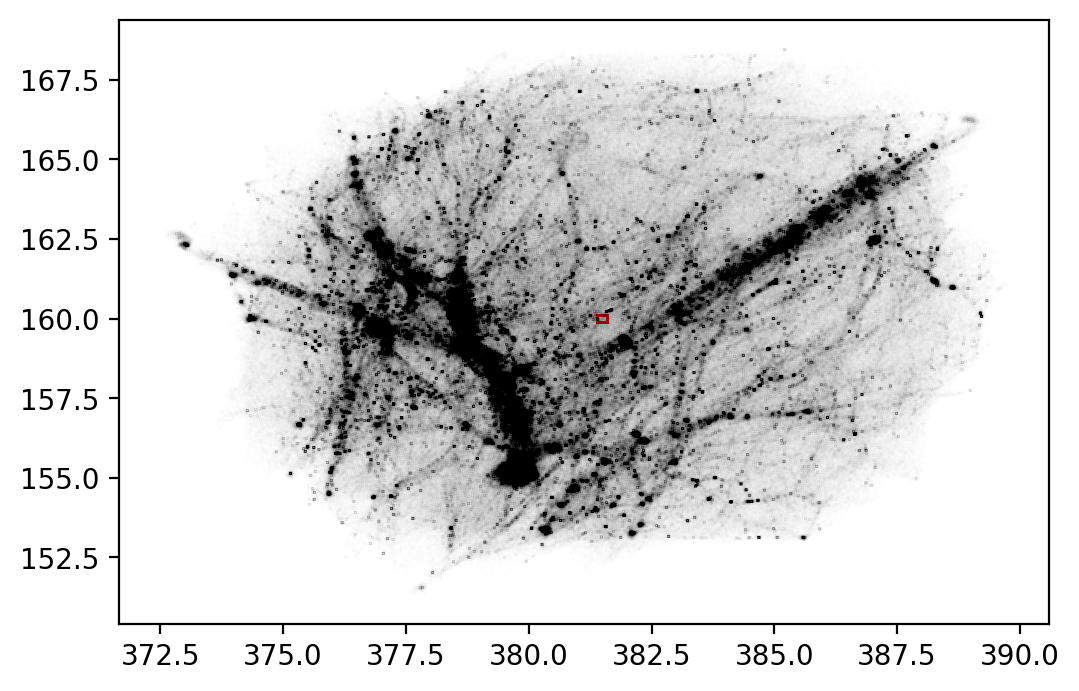

In [18]:
plt.figure(dpi=200)
plt.plot(pos[::10,0], pos[::10,2],'k.', markersize=0.25, alpha=0.01)
side_length = 0.20
center_x = 381.5
center_y = 160
# Calculate the bottom left corner of the square
bottom_left_x = center_x - side_length / 2
bottom_left_y = center_y - side_length / 2

# Create the square box
square_box = plt.Rectangle((bottom_left_x, bottom_left_y), side_length, side_length, edgecolor='r', facecolor='none')

# Add the square box to the plot
plt.gca().add_patch(square_box)
plt.show()

## Get DM Halo particles
Also gets halo IDs

In [ ]:
def plot_particles(which_host):
    sat_ids = halo_ids[field==massive_halo_ids[which_host]]
    print('Number of satellites', len(sat_ids))
    host_halo_part = getHaloDarkMatterMembers(snapshot, SOAP_membership, massive_halo_ids[which_host])
    host_star_part = getHaloStarsMembers(snapshot, SOAP_membership, massive_halo_ids[which_host])
    sat_halo_part = []
    sat_star_part = []
    for i in sat_ids:
        sat_halo_part.append(getHaloDarkMatterMembers(snapshot, SOAP_membership, i))
        sat_star_part.append(getHaloStarsMembers(snapshot, SOAP_membership, i))    
    sat_halo_part = np.array(sat_halo_part)
    sat_star_part = np.array(sat_star_part)
    fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
    ax[0].scatter(host_halo_part[::10,0], host_halo_part[::10,1], s=1, alpha = 0.2, c='black')
    ax[1].scatter(host_star_part[::10,0], host_star_part[::10,1], s=1, alpha = 0.2, c='black')
    #for sat in np.array(sat_star_part)[np.arange(len(sat_star_part))!=5]:
    for sat in sat_halo_part: #-4
        ax[0].scatter(sat[::10,0], sat[::10,1], s=1, alpha=0.2, c='red')
    for sat in sat_star_part: #-4
        ax[1].scatter(sat[::10,0], sat[::10,1], s=1, alpha=0.2, c='red')
    ax[1].set_title(f'Star particles of halo {which_host+1} and satellites')
    ax[0].set_title(f'Dark matter particles of halo {which_host+1} and satellites')
    fig.show()

## Plot particle distributions

In [24]:
def plot_particles(which_host):
    sat_ids = halo_ids[field==massive_halo_ids[which_host]]
    print('Number of satellites', len(sat_ids))
    host_halo_part = getHaloDarkMatterMembers(snapshot, SOAP_membership, massive_halo_ids[which_host])
    host_star_part = getHaloStarsMembers(snapshot, SOAP_membership, massive_halo_ids[which_host])
    sat_halo_part = []
    sat_star_part = []
    for i in sat_ids:
        sat_halo_part.append(getHaloDarkMatterMembers(snapshot, SOAP_membership, i))
        sat_star_part.append(getHaloStarsMembers(snapshot, SOAP_membership, i))    
    sat_halo_part = np.array(sat_halo_part)
    sat_star_part = np.array(sat_star_part)
    fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
    ax[0].scatter(host_halo_part[::10,0], host_halo_part[::10,1], s=1, alpha = 0.2, c='black')
    ax[1].scatter(host_star_part[::10,0], host_star_part[::10,1], s=1, alpha = 0.2, c='black')
    #for sat in np.array(sat_star_part)[np.arange(len(sat_star_part))!=5]:
    for sat in sat_halo_part: #-4
        ax[0].scatter(sat[::10,0], sat[::10,1], s=1, alpha=0.2, c='red')
    for sat in sat_star_part: #-4
        ax[1].scatter(sat[::10,0], sat[::10,1], s=1, alpha=0.2, c='red')
    ax[1].set_title(f'Star particles of halo {which_host+1} and satellites')
    ax[0].set_title(f'Dark matter particles of halo {which_host+1} and satellites')
    fig.show()

In [ ]:
def read_particles(which_host):
    sat_ids = halo_ids[field==massive_halo_ids[which_host]]
    #print(field[field==massive_halo_ids[which_host]])
    print('Number of satellites', len(sat_ids))
    host_halo_part = getHaloDarkMatterMembers(snapshot, SOAP_membership, which_host)
    host_star_part = getHaloStarsMembers(snapshot, SOAP_membership, which_host)
    sat_halo_part = []
    sat_star_part = []
    for i in sat_ids:
        sat_halo_part.append(getHaloDarkMatterMembers(snapshot, SOAP_membership, i))
        sat_star_part.append(getHaloStarsMembers(snapshot, SOAP_membership, i))
    sat_halo_part = np.array(sat_halo_part)
    sat_star_part = np.array(sat_star_part)
    return host_halo_part, host_star_part, sat_halo_part, sat_star_part, sat_ids

host_halo_part, host_star_part, sat_halo_part, sat_star_part, sat_ids = read_particles(1)

Number of satellites 138


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [147]:
def plot_hist_halos(host_halo_part, host_star_part, sat_halo_part, sat_star_part):
    #make host halo histogram
    host_halo_hist, host_halo_yedges, host_halo_xedges = np.histogram2d(host_halo_part[:,1], host_halo_part[:,0], bins=500)
    host_halo_H = np.where(host_halo_hist != 0, np.log(host_halo_hist), 1)
    
    #make host stars histogram
    host_star_hist, host_star_yedges, host_star_xedges = np.histogram2d(host_star_part[:,1], host_star_part[:,0], bins=500)
    host_star_H = np.where(host_star_hist != 0, np.log(host_star_hist), 1)
    
    #make satellite halo histogram
    sat_halo_hist, sat_halo_yedges, sat_halo_xedges = np.histogram2d(sat_halo_part[:,1], sat_halo_part[:,0], bins=500)
    sat_halo_H = np.where(sat_halo_hist != 0, np.log(sat_halo_hist), 1)
    
    #make satellite halo histogram
    sat_star_hist, sat_star_yedges, sat_star_xedges = np.histogram2d(sat_star_part[:,1], sat_star_part[:,0], bins=500)
    sat_star_H = np.where(sat_star_hist != 0, np.log(sat_star_hist), 1)    
    
    #arepo_H, arepo_yedges, arepo_xedges = np.histogram2d(coord_dm[:,1], coord_dm[:,0], bins=300)
    fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
    im1 = ax[0].imshow(host_halo_H, origin='lower', cmap = 'magma')
    im1 = ax[0].imshow(sat_halo_H, origin='lower', cmap = 'magma')
    ax[1].imshow(host_star_H, origin='lower', cmap = 'magma')
    ax[1].imshow(sat_star_H, origin='lower', cmap = 'magma')
    #for a in ax:
        #a.set_xlim(200, 300)
        #a.set_ylim(200, 300)
    for sat in sat_halo_part: #-4
        ax[0].scatter(sat[:,1], sat[:,2], s=1, alpha=0.2, c='red')
    for sat in sat_star_part: #-4
        ax[1].scatter(sat[:,1], sat[:,2], s=1, alpha=0.2, c='red')
    
    #fig.colorbar(im1)
    ax[1].set_title(f'Star particles of halo and satellites')
    ax[0].set_title(f'Dark matter particles of halo and satellites')
    fig.show()

In [ ]:
#sat_halo_part
plot_hist_halos(host_halo_part, host_star_part, sat_halo_part, sat_star_part)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Get stellar mass vs. distance to host

In [8]:
#find the centers of the satellite halos
#get units?

def satellite_mass_distributions(which_host):

    #get stellar mass
    total_mass = np.array(soap['BoundSubhaloProperties/TotalMass'])[field==massive_halo_ids[which_host]]
    stellar_mass = np.array(soap['BoundSubhaloProperties/StellarMass'])[field==massive_halo_ids[which_host]]
    fig, [ax1, ax2] = plt.subplots(1, 2, dpi=150, figsize=(10,5))
    ax1.hist(np.log(np.ma.array(total_mass[field==massive_halo_ids[which_host]])), label='DM mass', histtype='step')
    ax2.hist(np.log(np.ma.array(mstar[field==massive_halo_ids[which_host]])), label='Stellar mass', histtype='step')
    ax1.set_title('Total distribution')
    ax2.set_title('M* distribution')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    #fig.legend()
    fig.show()

## Suggested explorations for LMC objects:
- Star formation histories (easy)
- Stellar Mass function (easy)
- Baryonic component of LMCs
    - Gas rich? Rotating?
    - Metallicity

In [21]:
# see biggest objects to look at satellites (smaller ones won't have satellites) (LMC, stellar mass 10^9) how can we get satellites?

# volume 15 might have larger objects

#particle type 4 is stars

#particles type 0 is gas

#type 1 is DM, type 2 is background DM (low res)

#SANITY CHECK: plot stellar mass (mstar and/or total mass) vs distance to host once satellites are found. Distance should not be more than 100-200kpc

#Velocity dispersion in stars (part type 4, so 6 columns one for each part type)
#dispersion is total over every direction